In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

In [3]:
from datafold.appfold import EDMDControl, KoopmanMPC
from datafold.dynfold import DMDControl
from datafold.dynfold.transform import TSCIdentity, TSCRadialBasis
from datafold.pcfold import InitialCondition, InverseQuadraticKernel, TSCDataFrame

## Data generation

### Inverted pendulum Physics
A test model implemented in datafold is used to generate example data in this tutorial. A pendulum and a moving cart are connected by a swivel, which allows the pendulum to freely rotate. The cart wheels spin on a rail, and the entire system is powered by a DC motor. The displacement of the cart $x$ and the angular rotation of the pendulum $\theta$ describe the movement of the pendulum (note that the time derivatives, $\dot x$ and $\dot \theta$, are also needed to describe the full state), and the voltage to the motor $u$ can be controlled.

In [4]:
from datafold.utils._systems import InvertedPendulum

state_cols = ["x", "xdot", "theta", "thetadot"]
control_cols = ["u"]

### Creating the training set
The training set will consists of 20 different trajectories of 10 seconds each, discretized at 0.01 s time steps. The initial conditions of all trajectories is the same, and the control input is a sinusoidal signal of varying amplitude, frequency and phase. The 20 timeseries are concatenated into a `TSCDataFrame`.

In [5]:
# Data generation parameters
sim_time_step = 0.01  # s
sim_num_steps = 1000  # -
training_size = 20  # -
ic = InitialCondition.from_array(np.array([0, 0, np.pi, 0]), columns=state_cols)

In [6]:
invertedPendulum = InvertedPendulum(initial_condition=ic.values)

Xlist, Ulist = [], []
np.random.seed(42)
for i in range(training_size):
    control_amplitude = 0.1 + 0.9 * np.random.random()
    control_frequency = np.pi + 2 * np.pi * np.random.random()
    control_phase = 2 * np.pi * np.random.random()
    control_func = lambda t, y: control_amplitude * np.sin(
        control_frequency * t + control_phase
    )
    invertedPendulum.reset()
    traj = invertedPendulum.predict(
        time_step=sim_time_step,
        num_steps=sim_num_steps,
        control_func=control_func,
    )
    assert (
        invertedPendulum.sol.success
    ), f"Divergent solution for amplitude={control_amplitude}, frequency={control_frequency}"
    t = invertedPendulum.sol.t
    dfx = pd.DataFrame(data=traj.T, index=t, columns=state_cols)
    dfx[control_cols] = 0.0
    Xlist.append(dfx)
    control_input = control_func(t, traj)
    dfu = pd.DataFrame(data=control_input, index=t, columns=control_cols)
    for col in state_cols:
        dfu[col] = 0.0
    dfu = dfu[state_cols + control_cols]
    Ulist.append(dfu)

X_tsc = TSCDataFrame.from_frame_list(Xlist)[state_cols]
X_tsc[control_cols] = TSCDataFrame.from_frame_list(Ulist)[control_cols]
X_tsc

feature          x      xdot     theta  thetadot         u
ID time                                                   
0  0.00   0.000000  0.000000  3.141593  0.000000 -0.434292
   0.01  -0.000143 -0.028343  3.141110 -0.095568 -0.436980
   0.02  -0.000562 -0.055111  3.139699 -0.185484 -0.436041
   0.03  -0.001239 -0.080158  3.137421 -0.268933 -0.431481
   0.04  -0.002158 -0.103345  3.134346 -0.345142 -0.423339
...            ...       ...       ...       ...       ...
19 9.96  -0.004673 -0.238609  3.215131 -0.248442 -0.276201
   9.97  -0.007081 -0.242790  3.212441 -0.288352 -0.275695
   9.98  -0.009529 -0.246686  3.209361 -0.326279 -0.274865
   9.99  -0.012015 -0.250292  3.205911 -0.362074 -0.273712
   10.00 -0.014535 -0.253606  3.202116 -0.395593 -0.272238

[20020 rows x 5 columns]

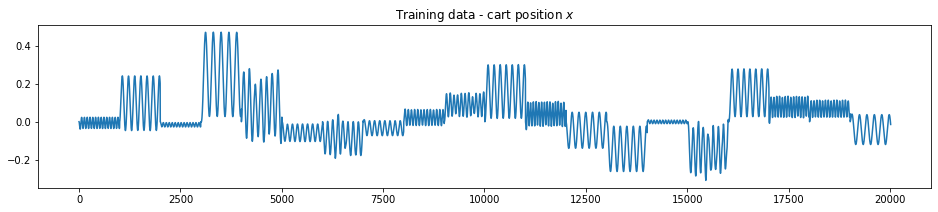

In [7]:
plt.figure(figsize=(16, 3))
plt.plot(X_tsc["x"].values)
plt.title(r"Training data - cart position $x$");

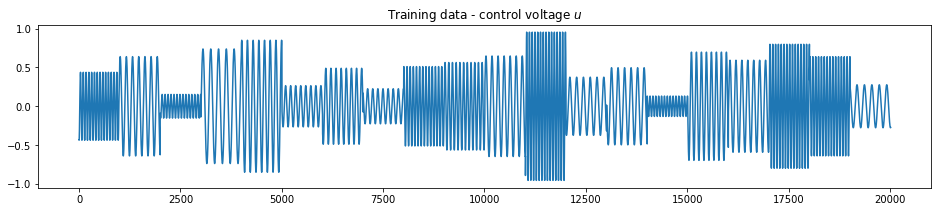

In [8]:
plt.figure(figsize=(16, 3))
plt.plot(X_tsc["u"].values)
plt.title(r"Training data - control voltage $u$");

## Estimators used to model the system 

### DMD predictor
In this section we demonstrate how to use the `DMDControl` class to create a Dynamic mode decomposition predictor for controlled systems using the data above.

The `DMDControl` class implements the `TSCPredictMixin` which is based on `scikit-learn` estimator-style interface. First we need to initialize the class and indicate which features will describe the state and which features the control input. Then we can use the `.fit` method to train the model, which in practice means finding $A$ and $B$ matrices which best satisfy $z^+ = Az + Bu$ ($z$ here refering to the state vector of the system).  

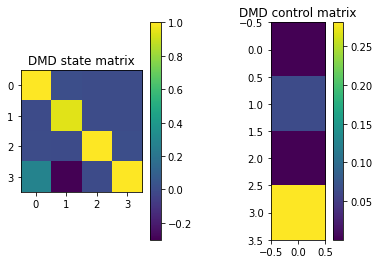

In [9]:
dmdc = DMDControl(state_columns=state_cols, control_columns=control_cols)
dmdc.fit(X_tsc)

plt.subplot(121)
plt.imshow(dmdc.sys_matrix_)
plt.colorbar()
plt.title("DMD state matrix")
plt.subplot(122)
plt.imshow(dmdc.control_matrix_)
plt.colorbar()
plt.title("DMD control matrix");

The `.predict` method can be used to estimate the trajectory of the system from a given initial condition and for a given control input.

In [10]:
prediction = dmdc.predict(
    ic,
    control_input=control_input,
    time_values=t,
)

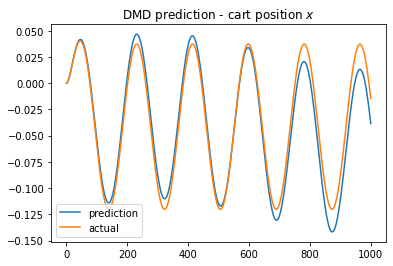

In [11]:
plt.plot(prediction["x"].values, label="prediction")
plt.plot(dfx["x"].values, label="actual")
plt.legend()
plt.title(r"DMD prediction - cart position $x$");

### EDMD Predictor
The EDMD approach uses a dictionary of lifting function to compute a finite-dimensional estimate for the Koopman operator of the underlying system using the available data. 

The `EDMDControl` class works similarly to the `DMDControl` class, but requires additionally that a lifting dictionary `dict_steps` is provided (see Tutorial 6 on EDMD for more further details). It is also important to provide the correct value of the `include_id_state` parameter depending on whether the dictionary natrually includes or not the original state - if the original state is included (e.g. when using transformers `TSCIdentity` or `TSCTakensEmbedding`, then `inculde_id_state=False`, but when using `TSCRadialBasis` -- `include_id_state=True`.)
The `EDMDControl` class also provides a `.transform` method to directly access the lifting function of the dictionary.

#### Using Identity dictionary
This is equivalent to using the DMD method, since the dictionary consists only of the original features. Here it is used to introduce the interface to the method. Here it can be seen that the split between state and control can also be provided to the `.fit` method (which is also the case for the `DMDControl` class).

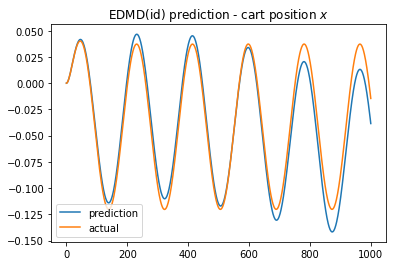

In [12]:
edmdid = EDMDControl(dict_steps=[("id", TSCIdentity()),], include_id_state=False).fit(
    X_tsc,
    split_by="name",
    state=state_cols,
    control=control_cols,
)
idprediction = edmdid.predict(ic, control_input=control_input, time_values=t)
plt.plot(idprediction["x"].values, label="prediction")
plt.plot(dfx["x"].values, label="actual")
plt.legend()
plt.title(r"EDMD(id) prediction - cart position $x$");

#### Using a realistic dictionary
Here we use a realistic dictionary of 100 randomly selected RBF centers from a inverse quadratic kernel. 

Please note that using `TSCRadialBasis` transofrmer with `center_type='fit_params'` requires passing the `centers` parameters to the `.fit` method of transformer using the `fit_params` as detailed in the documentation.

In [13]:
num_rbfs = 100
eps = 1

rbf = TSCRadialBasis(
    kernel=InverseQuadraticKernel(epsilon=eps), center_type="fit_params"
)
center_ids = sorted(
    np.random.choice(
        range(0, sim_num_steps * training_size), size=num_rbfs, replace=False
    )
)
centers = X_tsc.iloc[center_ids].values

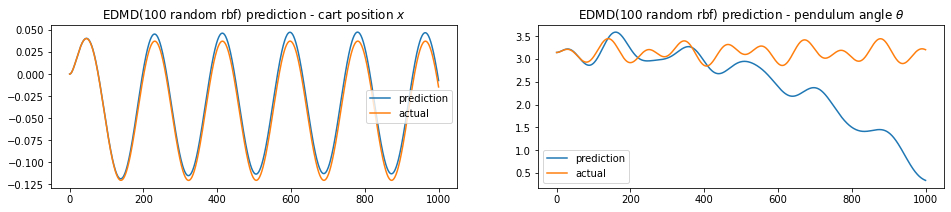

In [14]:
edmdrbf = EDMDControl(dict_steps=[("rbf", rbf),], include_id_state=True).fit(
    X_tsc,
    split_by="name",
    state=state_cols,
    control=control_cols,
    rbf__centers=centers[:, :-1],
)
rbfprediction = edmdrbf.predict(
    ic, control_input=np.atleast_2d(control_input).T, time_values=t
)
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.plot(rbfprediction["x"].values, label="prediction")
plt.plot(dfx["x"].values, label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - cart position $x$")
plt.subplot(122)
plt.plot(rbfprediction["theta"].values, label="prediction")
plt.plot(dfx["theta"].values, label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - pendulum angle $\theta$");

In the figure above we can see the the EDMD predicts the displacement even better than the DMD, but the prediction for $\theta$ is good only on a short time scale.

## Koopman Model Predictive Control

Model Predictive Control (MPC) is a method for estimating a control signal to provide to a system to achieve certain behaviour in the future. Here we show an implementation of a Koopman MPC (KMPC) where the model part is based on the Koopman operator. The `KoopmanMPC` class implements such a controller based on the `EDMDControl` class illustrated above. The key benefit is that the model is a linear system in the lifted space and the optimal control can be directly computed using quadratic programming optimizer.

An important parameter for MPCs is the prediction horizon, which denotes how far in the future is the control signal computed. Here we set it to 100 timesteps (1 second). The optimality of the signal is computed using a cost function of the referenced states (`qois`) and the control signal itself. Here we provide both $x$ and $\theta$ as referenced states, but set the running cost weight of $\theta$ to 0 to showcase the functionality of the interface.

In [15]:
horizon = 100

kmpc = KoopmanMPC(
    predictor=edmdrbf,
    horizon=horizon,
    state_bounds=np.array([[1, -1], [6.28, 0]]),
    input_bounds=np.array([[5, -5]]),
    qois=["x", "theta"],
    cost_running=np.array([100, 0]),
    cost_terminal=1,
    cost_input=1,
)

To generate the control signal, a full initial state is required, in addition to a reference to track. Here we use a reference  produced by a known control signal in the training data, so as to be able to later compare it to the optimal control signal computed by the controller.

In [16]:
reference = dfx[["x", "theta"]].iloc[: horizon + 1]
ukmpc = kmpc.generate_control_signal(rbfprediction.initial_states(), reference)

Further more, we compute what trajectory the model has predicted based on the control signal computed by the controller and what is the real response of the system.

In [17]:
kmpcpred = edmdrbf.predict(rbfprediction.initial_states(), control_input=ukmpc)
invertedPendulum.reset()
kmpcfunc = lambda t, y: np.interp(t, rbfprediction.time_values()[:horizon], ukmpc)
kmpctraj = invertedPendulum.predict(
    time_step=sim_time_step,
    num_steps=horizon,
    control_func=kmpcfunc,
)
kmpctraj = pd.DataFrame(data=kmpctraj.T, columns=state_cols)

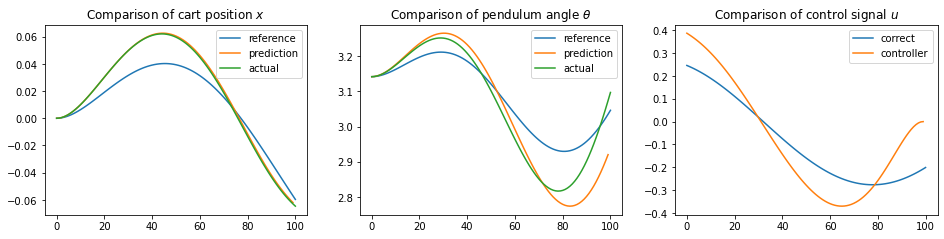

In [18]:
plt.figure(figsize=(16, 3.5))
plt.subplot(131)
plt.plot(dfx["x"].values[: horizon + 1], label="reference")
plt.plot(kmpcpred["x"].values, label="prediction")
plt.plot(kmpctraj["x"].values, label="actual")
plt.legend()
plt.title(r"Comparison of cart position $x$")
plt.subplot(132)
plt.plot(dfx["theta"].values[: horizon + 1], label="reference")
plt.plot(kmpcpred["theta"].values, label="prediction")
plt.plot(kmpctraj["theta"].values, label="actual")
plt.legend()
plt.title(r"Comparison of pendulum angle $\theta$")
plt.subplot(133)
plt.plot(dfu["u"].values[: horizon + 1], label="correct")
plt.plot(ukmpc, label="controller")
plt.legend()
plt.title(r"Comparison of control signal $u$");